# Toxic Comments - Some basic data analysis!

Based on the data from the Kaggle competition: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [7]:
import numpy as np
import pandas as pd
#from emo_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import math

import string
import re    #for regex

#nlp
import string
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

#from sklearn.model_selection import train_test_split
#from collections import Counter

#settings
color = sns.color_palette()
sns.set_style("dark")

nltk.download('stopwords')
nltk.download('punkt')
eng_stopwords = set(stopwords.words("english"))

tokenizer=TweetTokenizer()


%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/tom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
path = 'data/'
comp = 'jigsaw-toxic-comment-classification-challenge/'

train = pd.read_csv(f'{path}{comp}/train.csv',encoding = 'utf8')
test = pd.read_csv(f'{path}{comp}/test.csv',encoding = 'utf8')

In [9]:
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [10]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


## Class Imbalances

In [11]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
train['clean'].astype(int)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [12]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


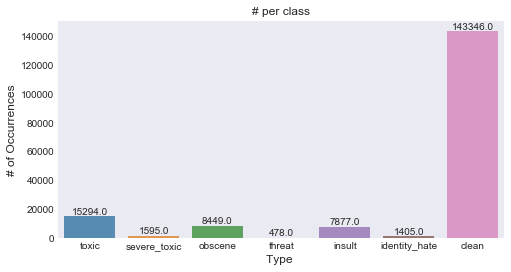

In [13]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

- The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
  - There are ~160k comments in the training dataset and there are ~35 k tags and ~143k clean comments!?
  - This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene.


## Multiple Tagging

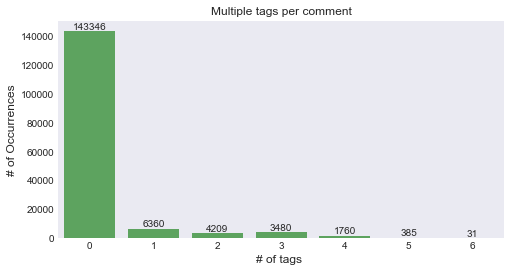

In [14]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

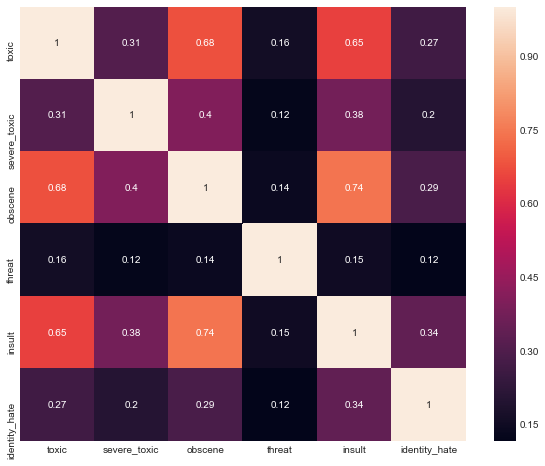

In [15]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [16]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
#out = out.style.apply(highlight_min,axis=0)
out

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  144277     0  143754   523  144248   29  143744   533   
1                   13699  1595    7368  7926   14845  449    7950  7344   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   144174   103  
1                    13992  1302

- all severe toxic comments are also toxic
- all other classes seem to be a subset of toxic with a few exceptions

## Comment statistics

In [17]:
## Indirect features
df = train.copy()
#df['comment_text']=df["comment_text"].apply(lambda x: [w for w in str(x).lower().split() if w not in eng_stopwords])
    #lambda x: " ".join([w for w in str(x).lower().split() if w in eng_stopwords]))
                                    
#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


In [18]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.00000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,3.52074,67.273527,48.097323,394.073221,15.885418,2.974206,8.510782,30.200262,4.936961
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,5.96225,99.230702,54.436443,590.720282,36.649770,21.207633,15.684381,45.296447,7.220133
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,17.000000,16.000000,96.000000,4.000000,0.000000,2.000000,7.000000,4.330472
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.00000,36.000000,31.000000,205.000000,8.000000,1.000000,5.000000,16.000000,4.696429
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.00000,75.000000,59.000000,435.000000,17.000000,3.000000,9.000000,35.000000,5.105263
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,313.00000,1411.000000,816.000000,5000.000000,4942.000000,1352.000000,1000.000000,902.000000,1655.000000


## Distribution of sentences 

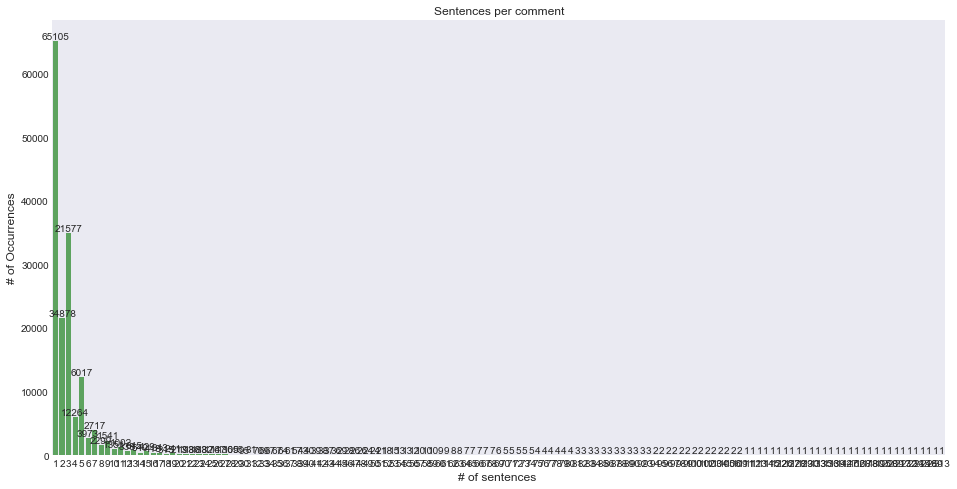

In [19]:
x=df['count_sent'].value_counts()

#plot
plt.figure(figsize=(16,8))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Sentences per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of sentences ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()